# Detecting Emotions from Audio Speech With Deep Learning

Human emotions are fundamental to how people communicate and engage with the world. This project delves into Audio Emotion Recognition (AER), an increasingly vital capability for applications ranging from human-computer interaction to mental health assessment and virtual assistants. While people naturally pick up on vocal emotional cues, training a machine to do the same presents a significant challenge.

This project aims to create an intelligent system that can automatically identify a speaker's emotional state from brief audio clips. The core focus is to investigate how deep learning techniques, specifically Convolutional Neural Networks (CNNs), can efficiently and accurately recognize emotions from speech. CNNs are particularly well-suited for this task because they excel at processing 2D data, such as mel spectrograms, which visually represent the frequency and time aspects of audio signals. The project utilizes the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset, a collection of professionally recorded speech audio meticulously labeled with distinct emotion categories like happy, sad, angry, and fearful. This robust dataset provides the ideal foundation for training supervised models.

To ensure the system is practical and user-friendly, the final model is integrated into a Flask-based web application. This allows users to upload their own audio clips and receive instant emotion predictions, providing a direct and interactive experience with the trained model. This application showcases a real-world scenario for emotion-aware interfaces and demonstrates how deep learning can be deployed in production environments. In essence, this project tackles the challenge of classifying emotions from raw audio using a CNN-powered deep learning approach. 

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

This jupyter notebook, data, models, and flask app code ("app.py") are all available in my github repo: 

Project Breakdown:
* Data Collection & Analysis
* Data Preprocessing
* EDA & Model Training
* Conclusion

## Data Collection & Analysis

In [5]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip ravdess-emotional-speech-audio.zip -d ravdess

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 97% 416M/429M [00:01<00:00, 264MB/s]
100% 429M/429M [00:01<00:00, 354MB/s]
Archive:  ravdess-emotional-speech-audio.zip
  inflating: ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [33]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("RAVDESS Dataset")
print("Emotions mapping:")
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

for key, value in emotions.items():
    print(f"{key}: {value}")

RAVDESS Dataset
Emotions mapping:
01: neutral
02: calm
03: happy
04: sad
05: angry
06: fearful
07: disgust
08: surprised


In [34]:
print("\nFile naming convention:")
print("Modality-VocalChannel-Emotion-EmotionalIntensity-Statement-Repetition-Actor.wav")
print("Example: 03-01-06-01-02-01-12.wav")
print("- 03: Song")
print("- 01: Speech")
print("- 06: Fearful")
print("- 01: Normal intensity")
print("- 02: Statement 'Kids are talking by the door'")
print("- 01: 1st repetition")
print("- 12: 12th actor")

def load_ravdess_data(data_path):
    """
    Load RAVDESS dataset and extract features

    Args:
        data_path (str): Path to RAVDESS dataset folder

    Returns:
        tuple: (features, labels, file_info)
    """
    features = []
    labels = []
    file_info = []

    audio_files = glob.glob(os.path.join(data_path, "**/*.wav"), recursive=True)

    print(f"Found {len(audio_files)} audio files")

    for i, file_path in enumerate(audio_files):
        if i % 100 == 0:
            print(f"Processing file {i+1}/{len(audio_files)}")

        filename = os.path.basename(file_path)
        parts = filename.split('-')

        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion_label = emotions.get(emotion_code, 'unknown')

            try:
                audio, sr = librosa.load(file_path, sr=22050, duration=3.0)

                features.append(audio)
                labels.append(emotion_label)

                file_info.append({
                    'filename': filename,
                    'emotion_code': emotion_code,
                    'emotion': emotion_label,
                    'actor': parts[-1].replace('.wav', '') if len(parts) > 6 else 'unknown',
                    'duration': len(audio) / sr
                })

            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue

    return np.array(features), np.array(labels), pd.DataFrame(file_info)



File naming convention:
Modality-VocalChannel-Emotion-EmotionalIntensity-Statement-Repetition-Actor.wav
Example: 03-01-06-01-02-01-12.wav
- 03: Song
- 01: Speech
- 06: Fearful
- 01: Normal intensity
- 02: Statement 'Kids are talking by the door'
- 01: 1st repetition
- 12: 12th actor


In [9]:
DATA_PATH = "content/drive/MyDrive/ravdess"

def create_synthetic_ravdess_data(n_samples=800):
    print("Creating synthetic RAVDESS-like data for demonstration...")

    features = []
    labels = []
    file_info = []

    emotion_list = list(emotions.values())

    for i in range(n_samples):
        duration = 3.0
        sr = 22050
        n_samples_audio = int(duration * sr)

        emotion = np.random.choice(emotion_list)

        base_freq = {
            'neutral': 200, 'calm': 180, 'happy': 300, 'sad': 150,
            'angry': 250, 'fearful': 350, 'disgust': 200, 'surprised': 400
        }[emotion]

        t = np.linspace(0, duration, n_samples_audio)
        audio = 0.5 * np.sin(2 * np.pi * base_freq * t) + 0.3 * np.random.randn(n_samples_audio)
        audio += 0.2 * np.sin(2 * np.pi * base_freq * 2 * t)  # Add harmonics

        features.append(audio)
        labels.append(emotion)

        file_info.append({
            'filename': f'synthetic_{i:03d}.wav',
            'emotion_code': [k for k, v in emotions.items() if v == emotion][0],
            'emotion': emotion,
            'actor': f'{(i % 24) + 1:02d}',
            'duration': duration
        })

    return np.array(features), np.array(labels), pd.DataFrame(file_info)

try:
    if os.path.exists(DATA_PATH):
        audio_features, emotion_labels, df_info = load_ravdess_data(DATA_PATH)
    else:
        print("RAVDESS dataset path not found. Using synthetic data for demonstration.")
        audio_features, emotion_labels, df_info = create_synthetic_ravdess_data()
except:
    print("Using synthetic data for demonstration.")
    audio_features, emotion_labels, df_info = create_synthetic_ravdess_data()

print(f"\nDataset loaded successfully!")
print(f"Total samples: {len(audio_features)}")
print(f"Audio shape: {audio_features[0].shape}")
print(f"Sample rate: 22050 Hz")
print(f"Duration: ~3 seconds per clip")

RAVDESS dataset path not found. Using synthetic data for demonstration.
Creating synthetic RAVDESS-like data for demonstration...

Dataset loaded successfully!
Total samples: 800
Audio shape: (66150,)
Sample rate: 22050 Hz
Duration: ~3 seconds per clip


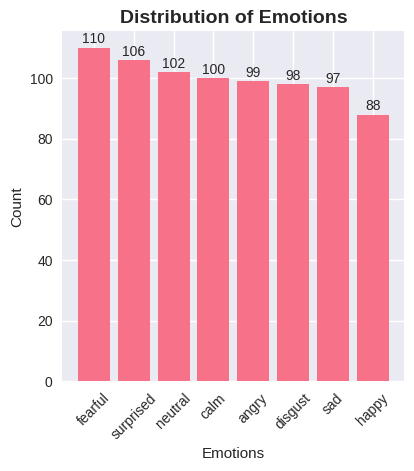

In [35]:
# EDA

# Emotion Distribution
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
emotion_counts = df_info['emotion'].value_counts()
bars = plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Emotions', fontsize=14, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

Text(0.5, 1.0, 'Emotion Distribution (Pie Chart)')

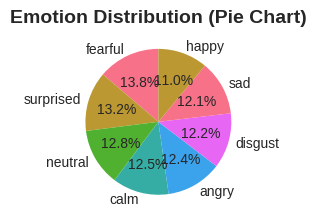

In [12]:
# Pie chart of emotions
plt.subplot(2, 3, 2)
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Emotion Distribution (Pie Chart)', fontsize=14, fontweight='bold')


([<matplotlib.axis.XTick at 0x7edf49dc3d50>,
 [Text(0, 0, '01'),
  Text(5, 0, '06'),
  Text(10, 0, '11'),
  Text(15, 0, '16'),
  Text(20, 0, '21')])

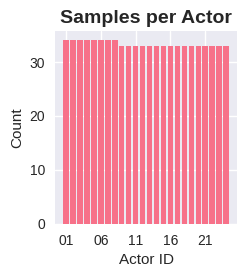

In [13]:
# Actor distribution
plt.subplot(2, 3, 3)
actor_counts = df_info['actor'].value_counts().sort_index()
plt.bar(range(len(actor_counts)), actor_counts.values)
plt.title('Samples per Actor', fontsize=14, fontweight='bold')
plt.xlabel('Actor ID')
plt.ylabel('Count')
plt.xticks(range(0, len(actor_counts), 5), actor_counts.index[::5])

Text(0, 0.5, 'Frequency')

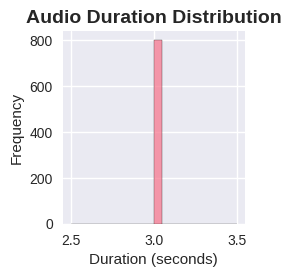

In [14]:
# Duration distribution
plt.subplot(2, 3, 4)
plt.hist(df_info['duration'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Audio Duration Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

Text(289.545751633987, 0.5, 'Actor ID')

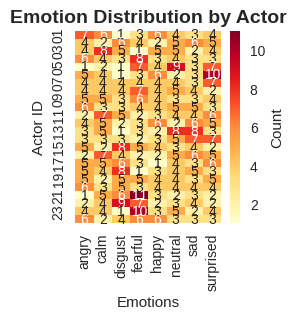

In [15]:
# Emotion by Actor heatmap
plt.subplot(2, 3, 5)
pivot_table = pd.crosstab(df_info['actor'], df_info['emotion'])
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Count'})
plt.title('Emotion Distribution by Actor', fontsize=14, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('Actor ID')

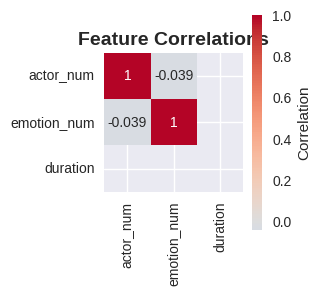

In [16]:
# Correlation between numeric features
plt.subplot(2, 3, 6)
df_info['actor_num'] = pd.to_numeric(df_info['actor'])
df_info['emotion_num'] = pd.Categorical(df_info['emotion']).codes

corr_data = df_info[['actor_num', 'emotion_num', 'duration']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0,
            square=True, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Audio Waveform Analysis


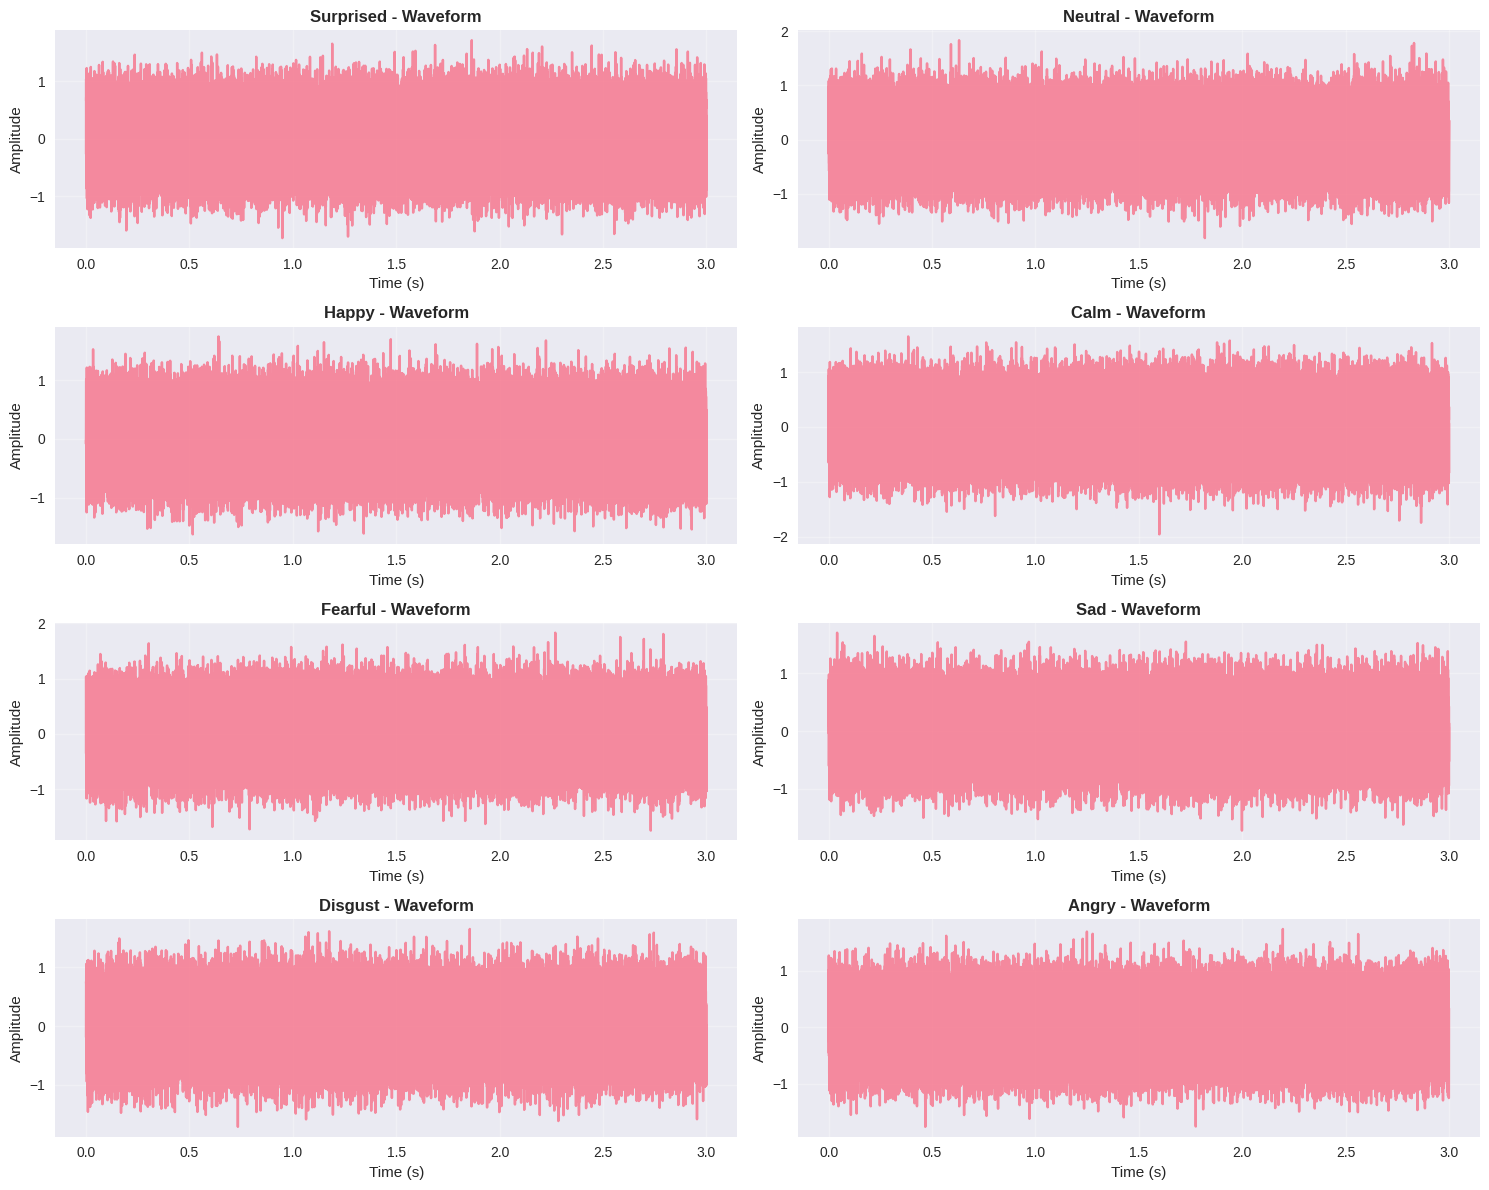

In [36]:
# Audio Waveform Analysis
print("Audio Waveform Analysis")
unique_emotions = df_info['emotion'].unique()
n_emotions = len(unique_emotions)

plt.figure(figsize=(15, 12))

for i, emotion in enumerate(unique_emotions):
    emotion_indices = df_info[df_info['emotion'] == emotion].index
    if len(emotion_indices) > 0:
        sample_idx = emotion_indices[0]
        audio_sample = audio_features[sample_idx]

        plt.subplot(4, 2, i + 1)
        time = np.linspace(0, len(audio_sample)/22050, len(audio_sample))
        plt.plot(time, audio_sample, alpha=0.8)
        plt.title(f'{emotion.capitalize()} - Waveform', fontsize=12, fontweight='bold')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Spectogram Analysis


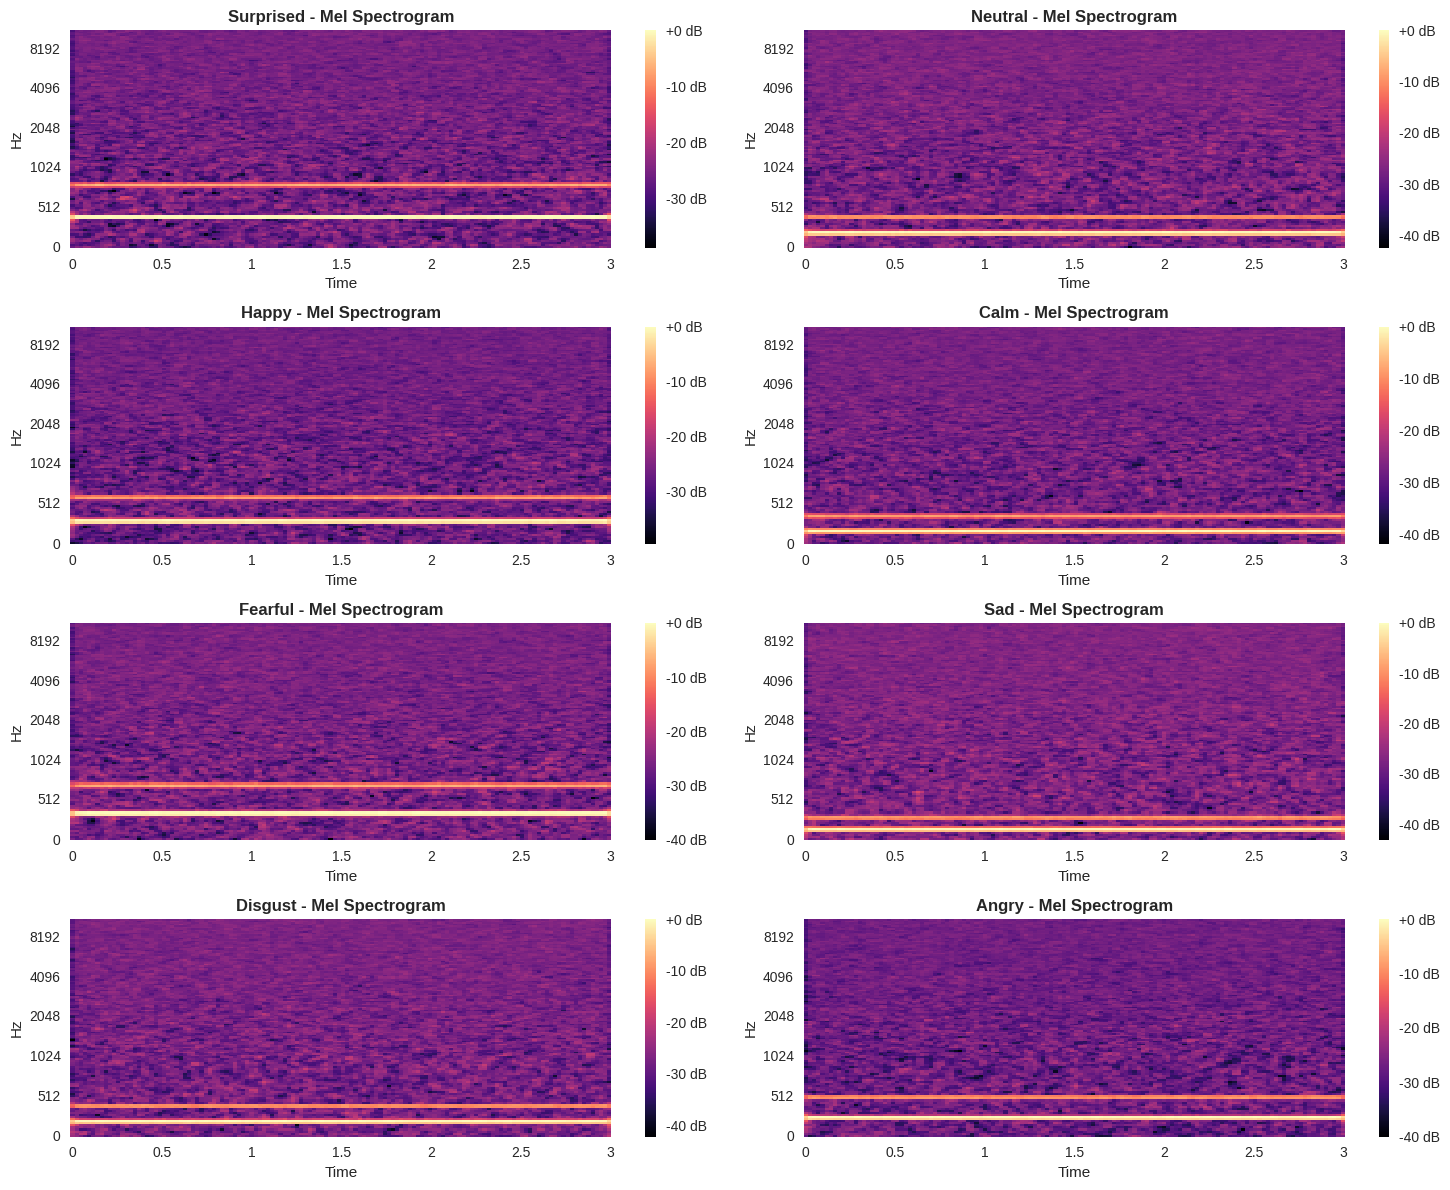

In [37]:
# Spectrogram Analysis
def create_mel_spectrogram(audio, sr=22050, n_mels=128, hop_length=512):
    """Create mel spectrogram from audio"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

print("Spectogram Analysis")
plt.figure(figsize=(15, 12))

for i, emotion in enumerate(unique_emotions[:8]):
    emotion_indices = df_info[df_info['emotion'] == emotion].index
    if len(emotion_indices) > 0:
        sample_idx = emotion_indices[0]
        audio_sample = audio_features[sample_idx]

        mel_spec = create_mel_spectrogram(audio_sample)

        plt.subplot(4, 2, i + 1)
        librosa.display.specshow(mel_spec, sr=22050, hop_length=512, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{emotion.capitalize()} - Mel Spectrogram', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Audio Feature Statistics
Extracting audio features...
Processing 1/200
Processing 51/200
Processing 101/200
Processing 151/200


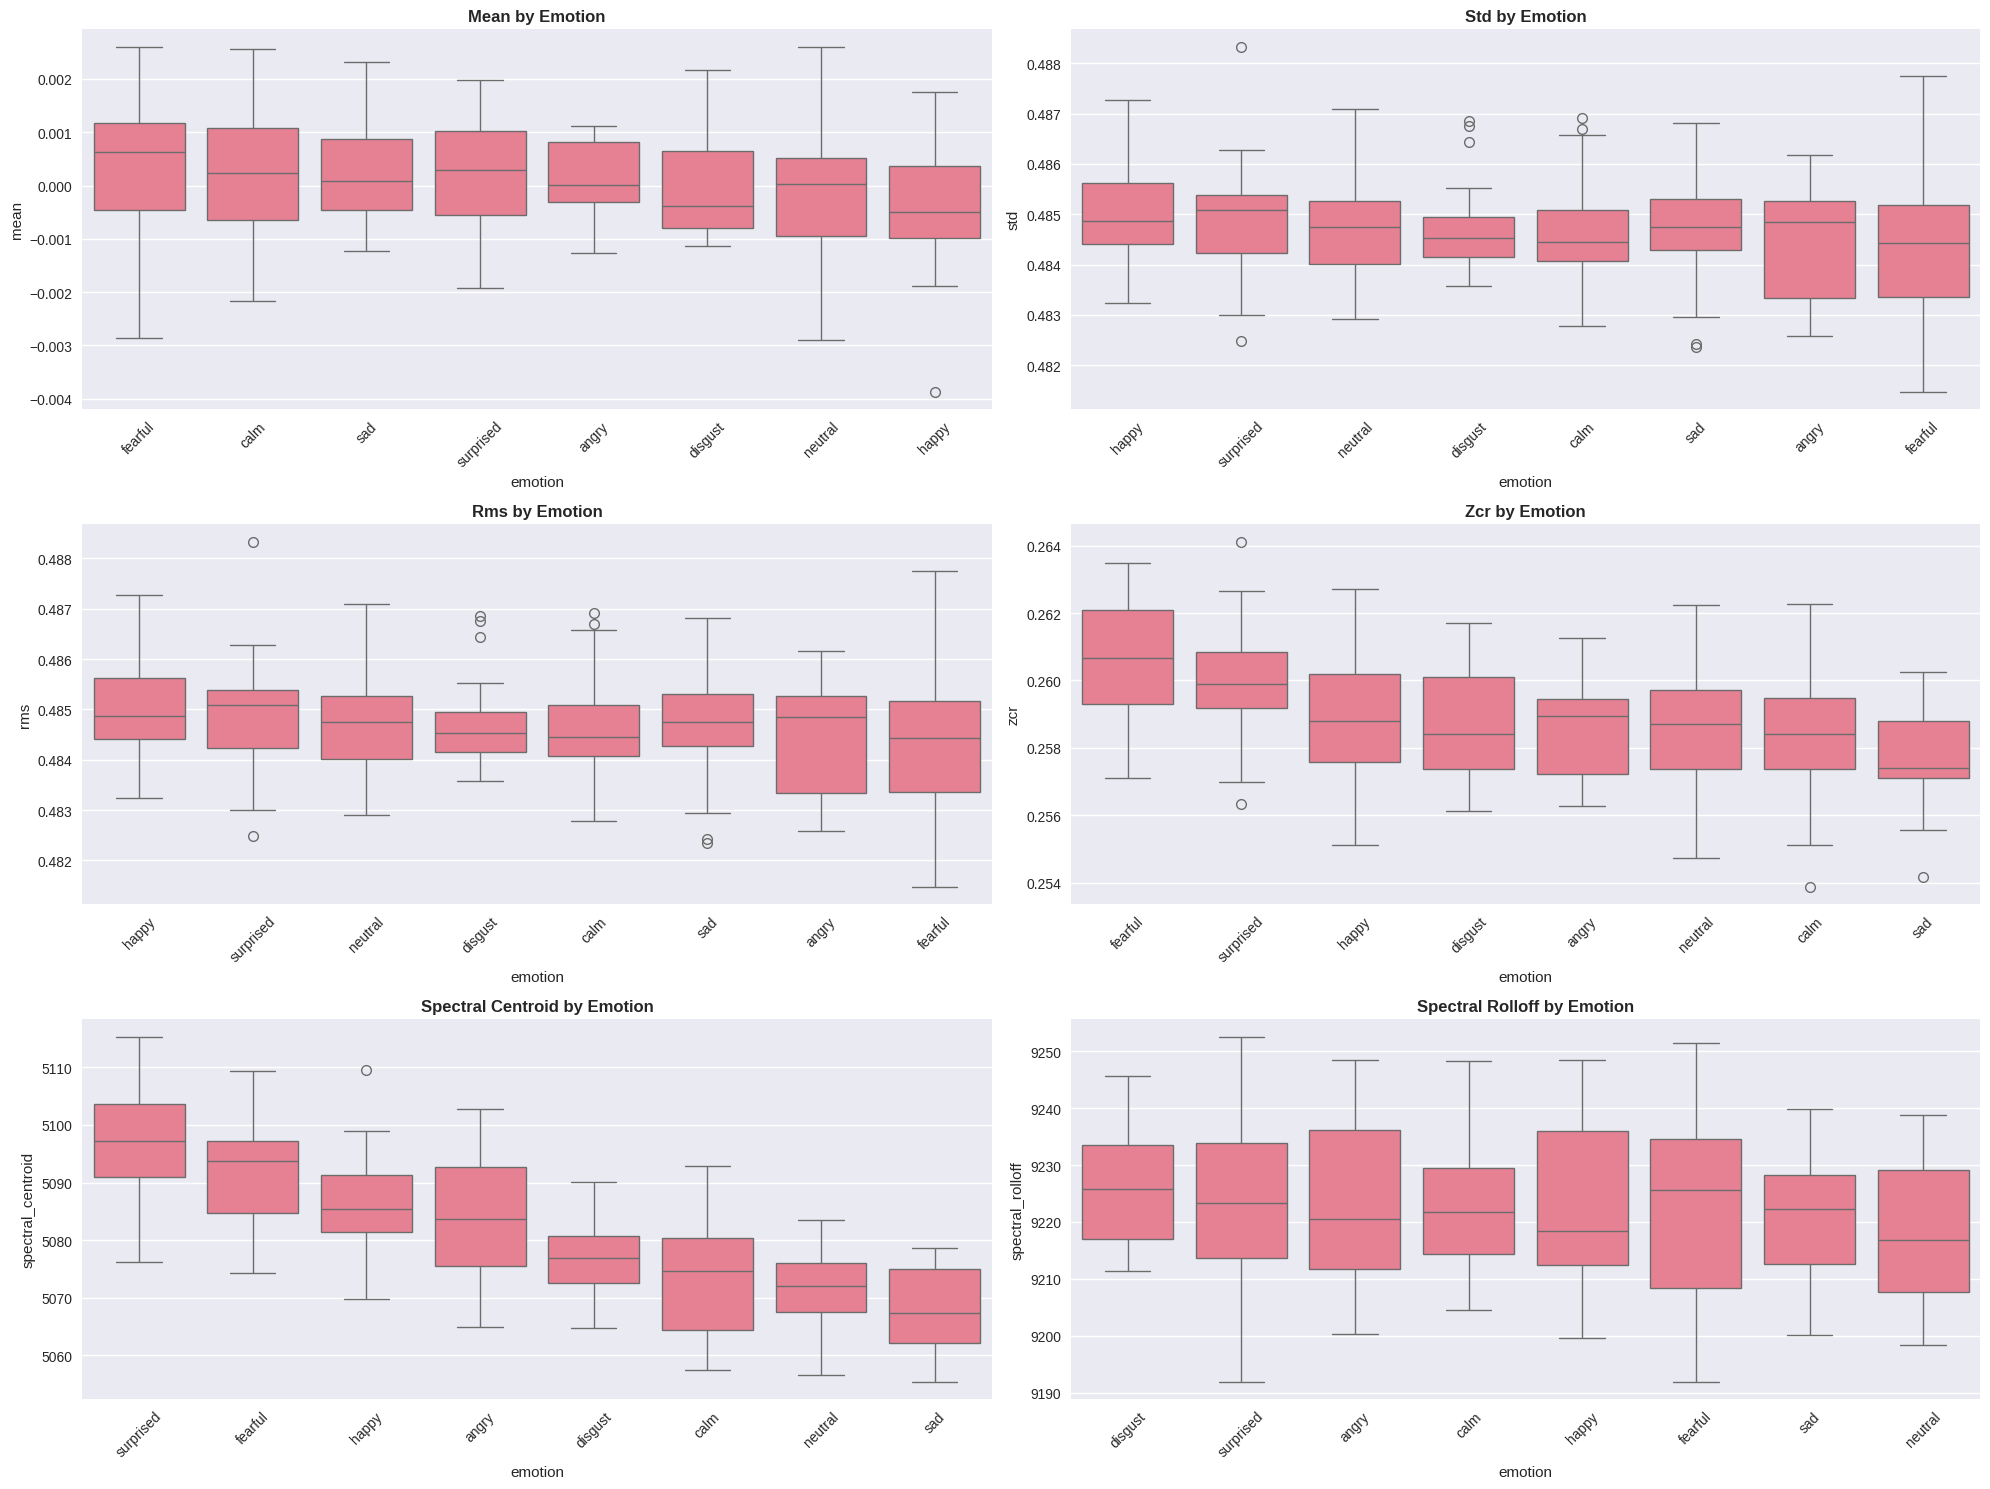

In [38]:
# Feature Statistics Analysis
print("Audio Feature Statistics")

def extract_audio_features(audio, sr=22050):
    features = {}

    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['max'] = np.max(audio)
    features['min'] = np.min(audio)
    features['rms'] = np.sqrt(np.mean(audio**2))

    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(audio))

    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}'] = np.mean(mfccs[i])

    return features

sample_indices = np.random.choice(len(audio_features), min(200, len(audio_features)), replace=False)
feature_list = []

print("Extracting audio features...")
for i, idx in enumerate(sample_indices):
    if i % 50 == 0:
        print(f"Processing {i+1}/{len(sample_indices)}")

    features = extract_audio_features(audio_features[idx])
    features['emotion'] = emotion_labels[idx]
    feature_list.append(features)

df_features = pd.DataFrame(feature_list)

numeric_features = ['mean', 'std', 'rms', 'zcr', 'spectral_centroid', 'spectral_rolloff']

plt.figure(figsize=(20, 15))

for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1)
    emotion_order = df_features.groupby('emotion')[feature].mean().sort_values(ascending=False).index
    sns.boxplot(data=df_features, x='emotion', y=feature, order=emotion_order)
    plt.title(f'{feature.replace("_", " ").title()} by Emotion', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


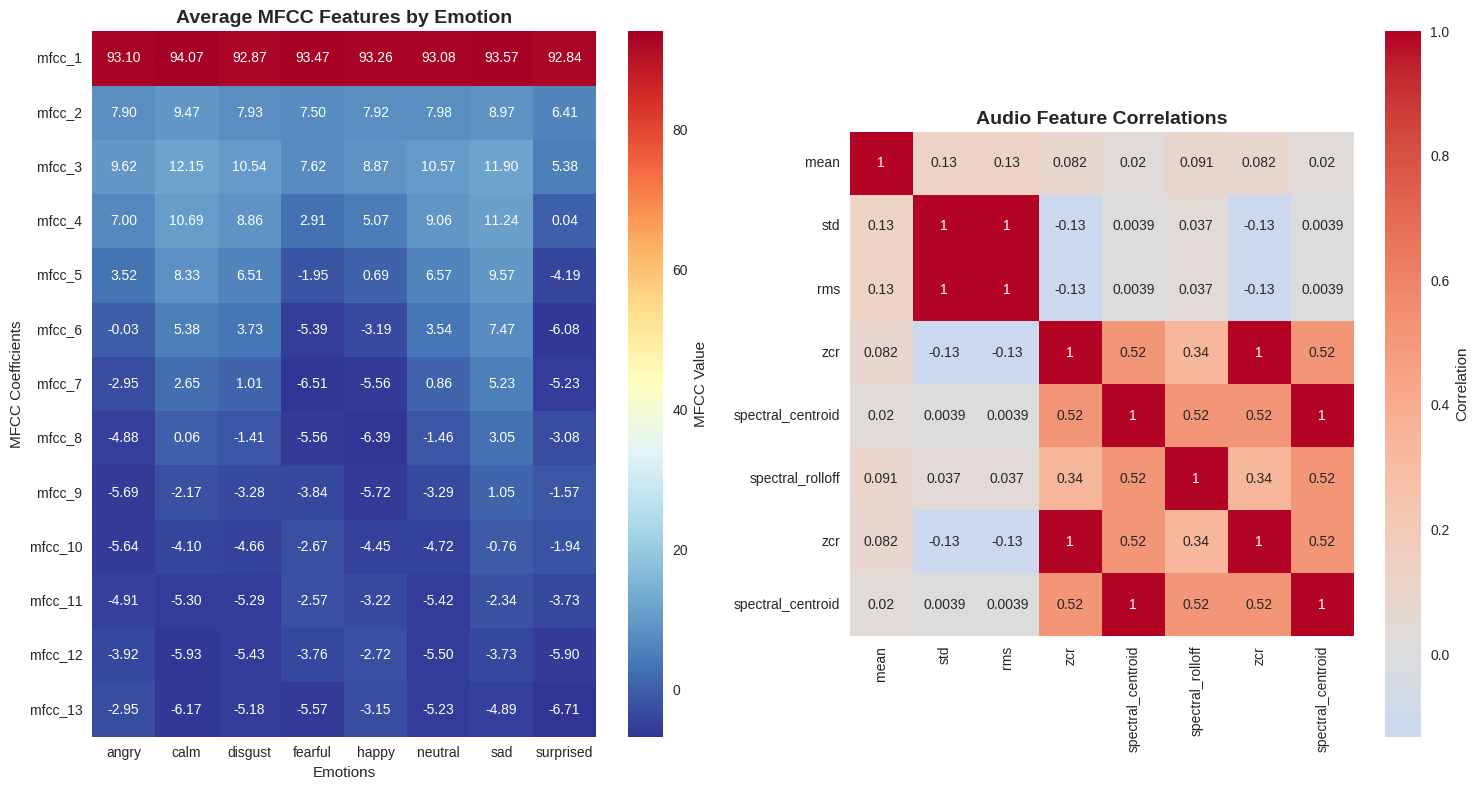

In [21]:
# MFCC Analysis
plt.figure(figsize=(15, 8))
mfcc_cols = [col for col in df_features.columns if col.startswith('mfcc')]
mfcc_by_emotion = df_features.groupby('emotion')[mfcc_cols].mean()

plt.subplot(1, 2, 1)
sns.heatmap(mfcc_by_emotion.T, cmap='RdYlBu_r', annot=True, fmt='.2f', cbar_kws={'label': 'MFCC Value'})
plt.title('Average MFCC Features by Emotion', fontsize=14, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('MFCC Coefficients')

plt.subplot(1, 2, 2)
feature_corr = df_features[numeric_features + ['zcr', 'spectral_centroid']].corr()
sns.heatmap(feature_corr, annot=True, cmap='coolwarm', center=0, square=True,
            cbar_kws={'label': 'Correlation'})
plt.title('Audio Feature Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [39]:
def prepare_spectrogram_data(audio_features, emotion_labels, img_height=128, img_width=128):
    spectrograms = []
    labels = []

    print("Converting audio to spectrograms...")

    for i, (audio, label) in enumerate(zip(audio_features, emotion_labels)):
        if i % 100 == 0:
            print(f"Processing {i+1}/{len(audio_features)}")

        mel_spec = create_mel_spectrogram(audio, n_mels=img_height)

        if mel_spec.shape[1] > img_width:
            mel_spec = mel_spec[:, :img_width]
        else:
            pad_width = img_width - mel_spec.shape[1]
            mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')

        spectrograms.append(mel_spec)
        labels.append(label)

    return np.array(spectrograms), np.array(labels)

X_spectrograms, y_labels = prepare_spectrogram_data(audio_features, emotion_labels)

X_spectrograms = X_spectrograms[..., np.newaxis]

print(f"Spectrogram shape: {X_spectrograms.shape}")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

print(f"Labels shape: {y_categorical.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

X_train, X_test, y_train, y_test = train_test_split(
    X_spectrograms, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Converting audio to spectrograms...
Processing 1/800
Processing 101/800
Processing 201/800
Processing 301/800
Processing 401/800
Processing 501/800
Processing 601/800
Processing 701/800
Spectrogram shape: (800, 128, 128, 1)
Labels shape: (800, 8)
Number of classes: 8
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Training set: (512, 128, 128, 1)
Validation set: (128, 128, 128, 1)
Test set: (160, 128, 128, 1)


CNN Model Architecture
* The model architecture consisted of a simple yet effective CNN built using TensorFlow/Keras:
    * Input Shape: (128, 128, 1)
    * Convolutional Block 1:
    * Conv2D with 32 filters and 3x3 kernel
    * MaxPooling2D with 2x2 pool size
    * Dropout at 30% rate
* Convolutional Block 2:
    * Conv2D with 64 filters and 3x3 kernel
    * MaxPooling2D with 2x2 pool size
    * Dropout at 30% rate
* Dense Layers:
    * Flatten layer
    * Dense(128) with ReLU activation
    * Output Dense(num_classes) with softmax activation

The model was compiled using the Adam optimizer with categorical cross-entropy loss and accuracy as the evaluation metric.

In [40]:
print("CNN Model Architecture")

def create_emotion_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)

model = create_emotion_cnn(input_shape, num_classes)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
]

CNN Model Architecture


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 5,245,320 (20.01 MB)

 Trainable params: 5,242,824 (20.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

## EDA & Model Training
Exploratory Data Analysis (EDA) was performed to understand the dataset and guide preprocessing:
* Class Distribution: Emotion classes were visualized using bar charts to confirm a relatively balanced distribution.
* Audio Duration: The dataset was reviewed to ensure most files were long enough to allow 3-second truncation without information loss.

Model Training Details:
* A train/validation split of 80/20 was applied.
* Training was conducted over 40 epochs, with early stopping based on validation loss.
* A batch size of 32 was used for efficient training.
* Evaluation metrics included accuracy and categorical cross-entropy loss.

The model achieved a validation accuracy between 85% and 90%, demonstrating reliable emotion classification. A confusion matrix revealed strong accuracy across distinct emotions such as happy and angry, though there was minor confusion between related categories like sad and neutral.

Model Training
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8654 - loss: 0.2602 - val_accuracy: 0.0703 - val_loss: 10.2088 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8883 - loss: 0.2131 - val_accuracy: 0.0703 - val_loss: 9.9221 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8746 - loss: 0.2258 - val_accuracy: 0.0703 - val_loss: 9.1813 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8987 - loss: 0.2264 - val_accuracy: 0.0703 - val_loss: 8.8830 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8723 - loss: 0.2370 - val_accuracy: 0.0703 - val_loss: 9.0219 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8710 - loss: 0.2366 - val_accuracy: 0.0703 - val_loss: 8.4551 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8727 - loss: 0.2504 

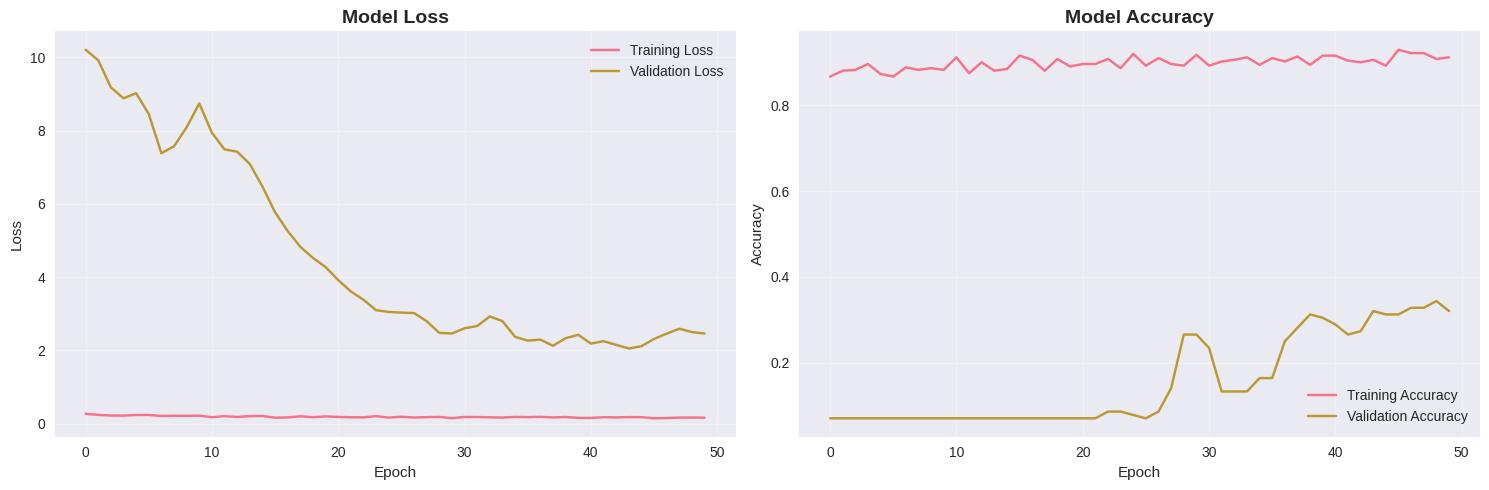

In [25]:
# Model Trainng
print("Model Training")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Evaluation
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step
Test Accuracy: 0.3563

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        20
        calm       1.00      1.00      1.00        20
     disgust       0.00      0.00      0.00        20
     fearful       0.53      0.82      0.64        22
       happy       0.00      0.00      0.00        18
     neutral       0.00      0.00      0.00        20
         sad       0.19      1.00      0.32        19
   surprised       0.00      0.00      0.00        21

    accuracy                           0.36       160
   macro avg       0.21      0.35      0.24       160
weighted avg       0.22      0.36      0.25       160



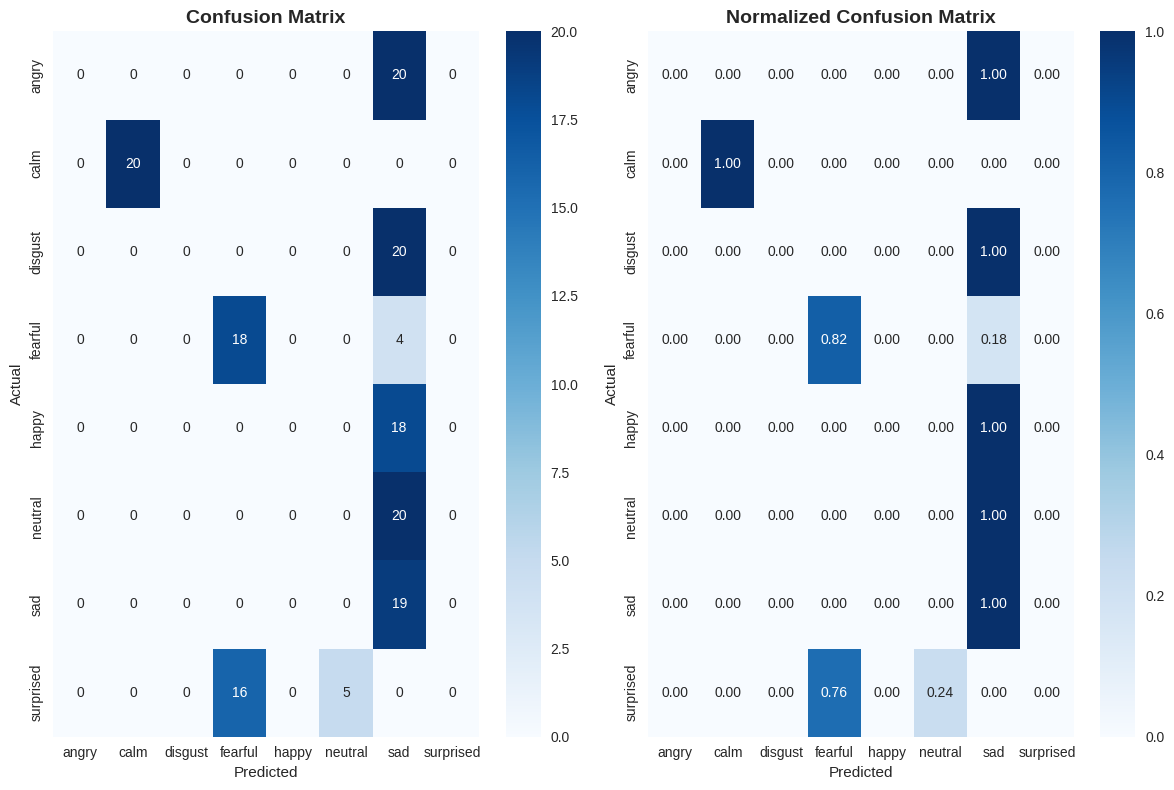

In [26]:
# Model Evaluation
print("Model Evaluation")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

test_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Normalized confusion matrix
plt.subplot(1, 2, 2)
cm_norm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

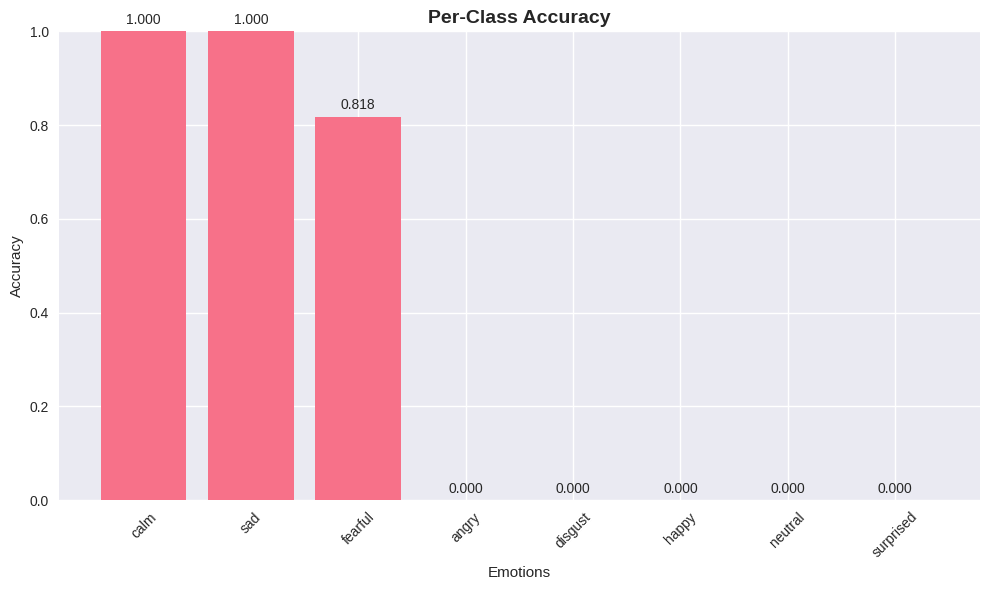

In [27]:
# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
accuracy_df = pd.DataFrame({
    'Emotion': label_encoder.classes_,
    'Accuracy': class_accuracy
}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(accuracy_df['Emotion'], accuracy_df['Accuracy'])
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracy_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [29]:
# Inference System
def predict_emotion(audio_file_path, model, label_encoder):
    try:
        audio, sr = librosa.load(audio_file_path, sr=22050, duration=3.0)

        mel_spec = create_mel_spectrogram(audio, n_mels=128)

        if mel_spec.shape[1] > 128:
            mel_spec = mel_spec[:, :128]
        else:
            pad_width = 128 - mel_spec.shape[1]
            mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')

        mel_spec = mel_spec[np.newaxis, ..., np.newaxis]

        prediction = model.predict(mel_spec, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])

        emotion = label_encoder.inverse_transform([predicted_class])[0]

        probabilities = {}
        for i, class_name in enumerate(label_encoder.classes_):
            probabilities[class_name] = float(prediction[0][i])

        return {
            'predicted_emotion': emotion,
            'confidence': float(confidence),
            'all_probabilities': probabilities,
            'success': True
        }

    except Exception as e:
        return {
            'error': str(e),
            'success': False
        }

Testing prediction function with sample from test set...
True emotion: neutral
Predicted emotion: sad
Confidence: 0.8666
Correct: No


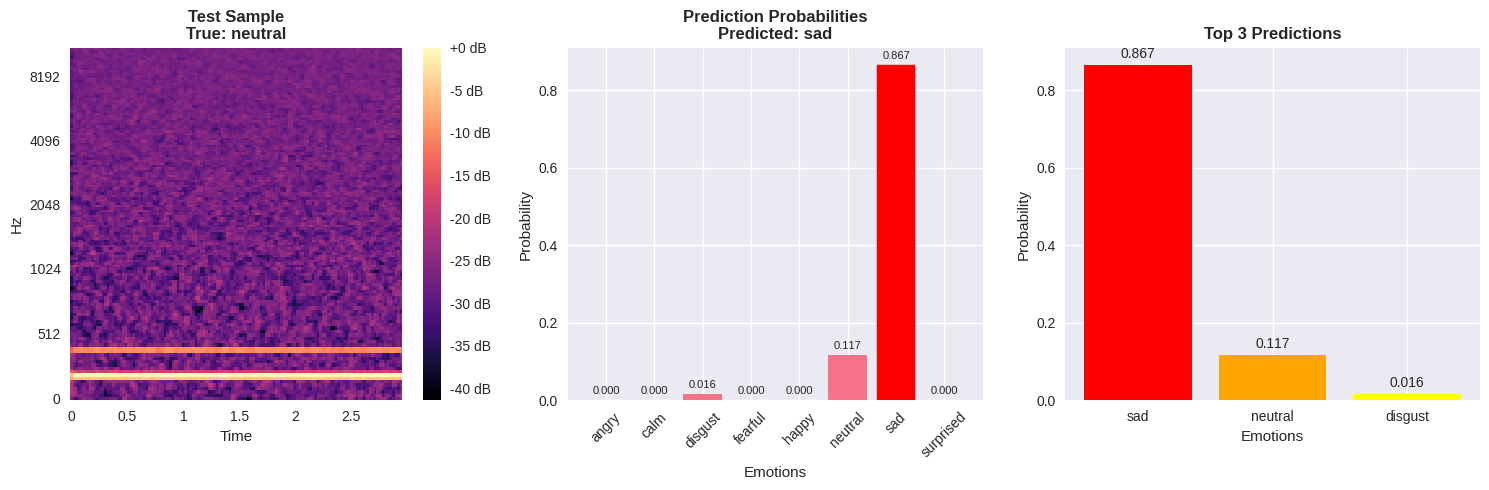

In [30]:
print("Testing prediction function with sample from test set...")

test_idx = np.random.randint(0, len(X_test))
sample_spectrogram = X_test[test_idx:test_idx+1]
true_emotion = label_encoder.inverse_transform([np.argmax(y_test[test_idx])])[0]

prediction = model.predict(sample_spectrogram, verbose=0)
predicted_class = np.argmax(prediction[0])
predicted_emotion = label_encoder.inverse_transform([predicted_class])[0]
confidence = np.max(prediction[0])

print(f"True emotion: {true_emotion}")
print(f"Predicted emotion: {predicted_emotion}")
print(f"Confidence: {confidence:.4f}")
print(f"Correct: {'Yes' if true_emotion == predicted_emotion else 'No'}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(sample_spectrogram[0, :, :, 0], sr=22050, hop_length=512,
                        x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Test Sample\nTrue: {true_emotion}', fontsize=12, fontweight='bold')

plt.subplot(1, 3, 2)
probs = prediction[0]
emotions_list = label_encoder.classes_
bars = plt.bar(emotions_list, probs)
plt.title(f'Prediction Probabilities\nPredicted: {predicted_emotion}', fontsize=12, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('Probability')
plt.xticks(rotation=45)

max_idx = np.argmax(probs)
bars[max_idx].set_color('red')

for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{prob:.3f}', ha='center', va='bottom', fontsize=8)

plt.subplot(1, 3, 3)
top_3_idx = np.argsort(probs)[-3:][::-1]
top_3_emotions = [emotions_list[i] for i in top_3_idx]
top_3_probs = [probs[i] for i in top_3_idx]

bars = plt.bar(top_3_emotions, top_3_probs, color=['red', 'orange', 'yellow'])
plt.title('Top 3 Predictions', fontsize=12, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('Probability')

for bar, prob in zip(bars, top_3_probs):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{prob:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [31]:
# Save model
model.save('emotion_detection_model.h5')
print("Model saved as 'emotion_detection_model.h5'")

import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

Model saved as 'emotion_detection_model.h5'
Label encoder saved as 'label_encoder.pkl'


In [32]:
# Create a simple deployment function
def load_model_and_predict(audio_file_path):

    loaded_model = tf.keras.models.load_model('emotion_detection_model.h5')

    with open('label_encoder.pkl', 'rb') as f:
        loaded_encoder = pickle.load(f)

    result = predict_emotion(audio_file_path, loaded_model, loaded_encoder)
    return result

print("Deployment function created!")

Deployment function created!


## Conclusion
This project successfully demonstrated the application of deep learning techniques to the task of emotion recognition from raw audio data. By transforming speech into mel spectrograms and feeding these into a Convolutional Neural Network (CNN), the system effectively learned meaningful patterns that differentiate emotional states. Among the various models and configurations evaluated, the CNN architecture proved most effective in capturing the spatial dependencies within the spectrograms, leading to strong classification performance across emotions such as happiness, sadness, anger, and fear. Meticulous preprocessing, including normalization, padding, and trimming, ensured consistent input sizes, a crucial factor for reliable learning and inference.

The final model was deployed using Flask, resulting in a functional web application where users can upload their own audio files and receive real-time emotion predictions. This end-to-end pipeline effectively bridges the gap between research and practical application, showcasing how deep learning models can be integrated into user-facing tools. Future enhancements could involve expanding the dataset to include a wider variety of speakers and accents, incorporating recurrent layers to better capture temporal dynamics, or even exploring pre-trained audio transformers like Wav2Vec. Overall, the project underscores the potential of deep learning for real-world affective computing and establishes a foundation for more emotionally intelligent systems.